# More Advanced Techniques (and Architectures)
We have thus far studied a number of convolutional networks for performing classification, specifically using the Fashion MNIST dataset. However, as the classification problem becomes more complicated, it will require more complicated architectures and more involved methods for regularizing the data. For instance, object recognition requires more knowledge than simple handwriting digits (as in the case of recognizing shirts in Fashion MNIST). The complexities of the picture are more varied, color has an influence, and much more. Therefore, the simple convolutions that we used before might not be expressive enough without a number of additional layers. 

Let's try some of these techniques with Fashion MNIST data. Some of these concepts we have already talked about, such as different initializations and different regularizers. Namely, we will cover these concepts:

- Expansion
- Initialization
- Parallel Pathways
- Building Blocks from More Advanced Networks (bypass, branching, etc.)

![resnet](PDF_Slides/CNN_Summary.png)

After going through this tutorial, you will have an understanding of how to use some of the more advanced techniques--however we are limited here by the hardware and time in lecture. Many modern architectures can take days/weeks to train and are extremely deep (look at the 100+ layers of ResNet-112). However, some of the architectures from ~2013 and ~2014 are manageable to investigate and take only a few hours to train. We will cover a few concepts for getting models up and running, and maybe even use more some complicated architectures. Let's get started! 

This is also an excellent tutorial with even more information than I am showing for the fine tuning techniques:
- https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model

keras.__version__

'2.12.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
# from skimage.io import imshow
import seaborn as sns
%matplotlib inline

labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
def summarize_net(net, ds_test, title_text=''):
    plt.figure(figsize=(15,5))
    # convert dataset to test set we can use with sklearn.metrics
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    yhat = np.argmax(net.predict(ds_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat.squeeze())
    cm = mt.confusion_matrix(y_test,yhat.squeeze())
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(f'{title_text} {acc:.4f}')
    
        

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [ ]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# import os
# import struct
# import numpy as np
 
# def load_mnist(path, kind='fashion_train'):
#     """Load MNIST data from `path`"""
#     labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
#     images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
#     with open(labels_path, 'rb') as lbpath:
#         magic, n = struct.unpack('>II', lbpath.read(8))
#         labels = np.fromfile(lbpath, dtype=np.uint8)

#     with open(images_path, 'rb') as imgpath:
#         magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
#         images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
#     return images, labels

# X_train, y_train = load_mnist('data/', kind='fashion_train')
# print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

# X_test, y_test = load_mnist('data/', kind='fashion_t10k')
# print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

# X_train = X_train/255.0 - 0.5
# X_test = X_test/255.0 - 0.5

# NUM_CLASSES = 10
# img_wh = 28

# # Let's start by fixing the sizes, channels last
# X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
# X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# # the image data has been resized to (samples,image_rows,image_cols,image_channels)

# # and one hot encoding the output values
# y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
# y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

In [24]:
# TODO: Change this to be something harder and larger? A small version of ImageNet? 

# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
 
def load_mnist(path, kind='fashion_train', is_test=False):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    # Let's start by fixing the sizes, channels last and normalizing
    images = images/255.0
    images = np.expand_dims(images.reshape((-1,28,28)), axis=3)
    # the image data has been resized to (samples,image_rows,image_cols,image_channels)
    
    # and one hot encoding the output values
    NUM_CLASSES = 10
    labels = keras.utils.to_categorical(labels, NUM_CLASSES)
    
    # create a dataset 
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if not is_test:
        # only shuffle the training set
        dataset = dataset.shuffle(1024) # buffer size for shuffeling data
    dataset = dataset.batch(128)
    
 
    return dataset

ds_train = load_mnist('data/', kind='fashion_train')
ds_test = load_mnist('data/', kind='fashion_t10k', is_test=True)



Image size: (28, 28, 1) , Classes: 10


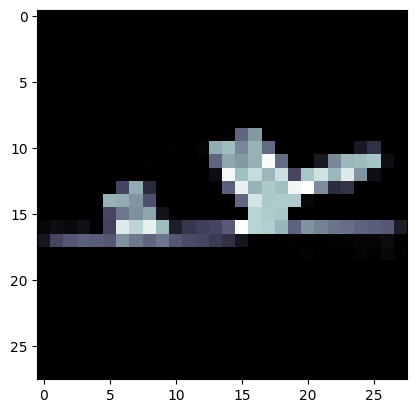

In [11]:
[(img_sample_tf, label_sample_tf)] = ds_train.take(1)

NUM_CLASSES = label_sample_tf.shape[1] # get one hot encoding dimension for the number of classes
img_wh = img_sample_tf[0].shape[0] # get the width and height for the image
print('Image size:',img_sample_tf[0].shape,', Classes:',NUM_CLASSES)

plt.subplot(1,1,1)
plt.imshow(img_sample_tf[0].numpy().squeeze(),cmap='bone')
plt.show()

## Starting simple
Let's first start by using data expansion on the Fashion MNIST dataset.

In [12]:
%%time 

cnn = Sequential()

# add in augmentations directly
cnn.add( RandomFlip("horizontal") )
cnn.add( RandomRotation(0.2) )

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

cnn.build((None,28,28,1))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)       

In [13]:
# now fit with random augmentations applied during training only
cnn.fit(ds_train, batch_size=128, 
                   epochs=5, verbose=1,
                   validation_data=ds_test
                  )

Epoch 1/5


2023-08-16 12:52:02.360892: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 19s 32ms/step - loss: 0.9554 - accuracy: 0.6654 - val_loss: 0.5881 - val_accuracy: 0.7883
Epoch 2/5
469/469 [==============================] - 15s 32ms/step - loss: 0.6428 - accuracy: 0.7744 - val_loss: 0.5104 - val_accuracy: 0.8229
Epoch 3/5
469/469 [==============================] - 15s 32ms/step - loss: 0.5651 - accuracy: 0.7999 - val_loss: 0.5108 - val_accuracy: 0.8227
Epoch 4/5
469/469 [==============================] - 15s 32ms/step - loss: 0.5218 - accuracy: 0.8164 - val_loss: 0.4638 - val_accuracy: 0.8385
Epoch 5/5
469/469 [==============================] - 15s 32ms/step - loss: 0.4938 - accuracy: 0.8249 - val_loss: 0.4808 - val_accuracy: 0.8419


79/79 [==============================] - 1s 10ms/step


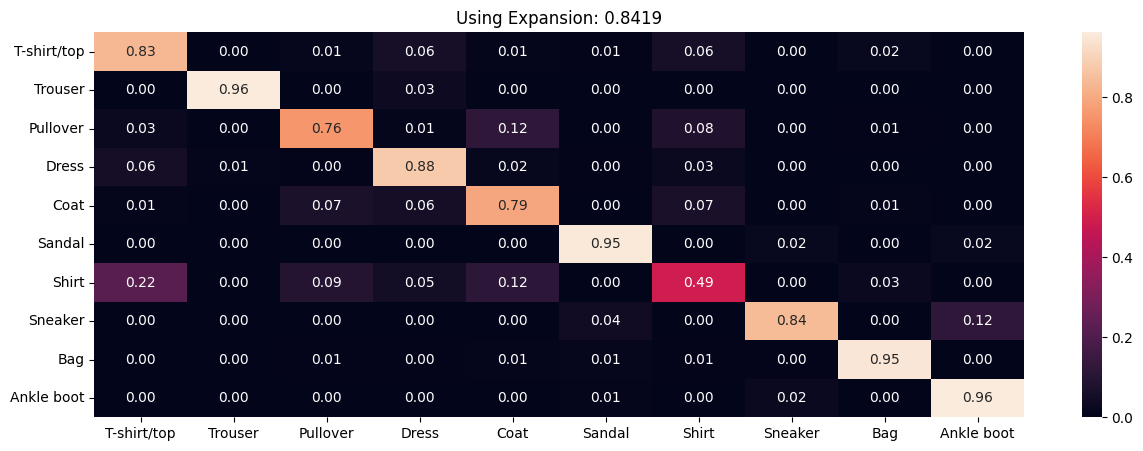

In [25]:
summarize_net(cnn, ds_test, title_text='Using Expansion:')

In [27]:
# what if we just want to use the validation data
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomContrast, RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

# add in augmentations directly
cnn.add( RandomFlip("horizontal") ) # flip horizontally
cnn.add( RandomRotation(0.05) ) # rotate by 5%
cnn.add( RandomTranslation(height_factor=0.1, width_factor=0.1) ) # move by 10%
cnn.add( RandomBrightness(factor=0.1, value_range=(0.0, 1.0)) ) # add some to the mean
cnn.add( RandomContrast(0.1) ) # add or decrease contrast


cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',
               data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

cnn.build((None,28,28,1))
cnn.summary()

# now fit with random augmentations applied during training only
cnn.fit(ds_train, batch_size=128, 
           epochs=50, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_3 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_translation (RandomT  (None, 28, 28, 1)        0         
 ranslation)                                                     
                                                                 
 random_brightness (RandomBr  (None, 28, 28, 1)        0         
 ightness)                                                       
                                                                 
 random_contrast (RandomCont  (None, 28, 28, 1)        0         
 rast)                                                

79/79 [==============================] - 1s 13ms/step


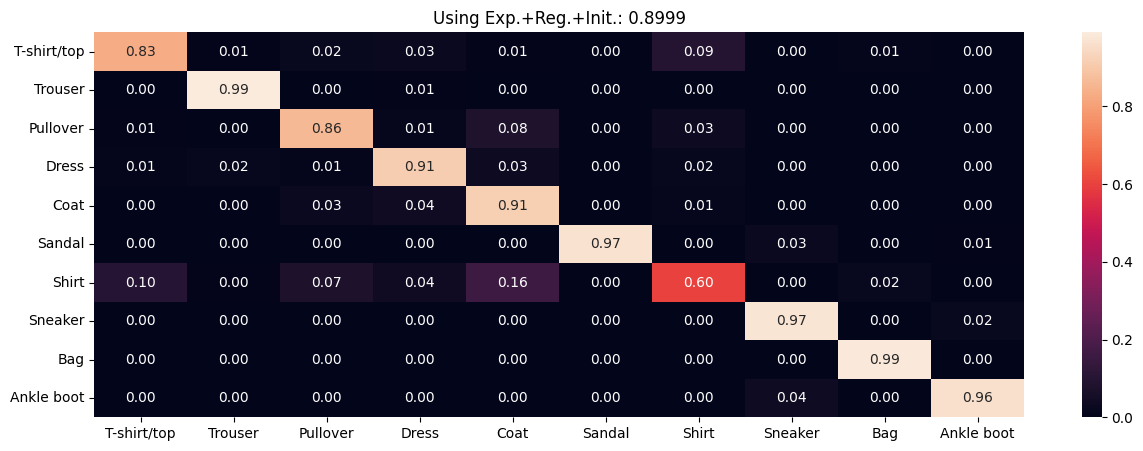

In [28]:
summarize_net(cnn, ds_test, title_text='Using Exp.+Reg.+Init.:')

# Ensemble Nets
Now lets do the exact same thing, but with an average of three separate networks. 

To get this running, we are going to use the keras `Model API` which is different than the `Sequential API`. It requires that we explicitly define the inputs and outputs, and gives us a bit more control over the network topology.

- https://keras.io/models/model/

Reminder of Differences from Sequential and Functional APIs:
- You will need to specify the input and output nodes explicitly.
 - `input_layer = Input(shape=(**insert shape here**))`
- You no longer `add` to a `Sequential`, you feed layer by layer:
 - `model.add(Dense())` becomes `layer2 = Dense()(input_layer)`
 - subsequent layers use temporary variables like `layer1` and `input_layer` above
- Tell the Model what the input and output temporary variables are:
 - `model = Model(inputs=input_layer,outputs=layer1)`
 - then you can call `model.compile()`
- A great example that uses the Model API with MNIST:
 - https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 random_flip_7 (RandomFlip)     (None, 28, 28, 1)    0           ['input_4[0][0]']                
                                                                                                  
 random_rotation_6 (RandomRotat  (None, 28, 28, 1)   0           ['random_flip_7[0][0]']          
 ion)                                                                                             
                                                                                                  
 random_translation_3 (RandomTr  (None, 28, 28, 1)   0           ['random_rotation_6[0][0]']

 dense_21 (Dense)               (None, 64)           36928       ['dropout_12[0][0]']             
                                                                                                  
 dense_18 (Dense)               (None, 10)           650         ['dense_17[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 10)           650         ['dense_19[0][0]']               
                                                                                                  
 dense_22 (Dense)               (None, 10)           650         ['dense_21[0][0]']               
                                                                                                  
 ens_concat (Concatenate)       (None, 30)           0           ['dense_18[0][0]',               
                                                                  'dense_20[0][0]',               
          

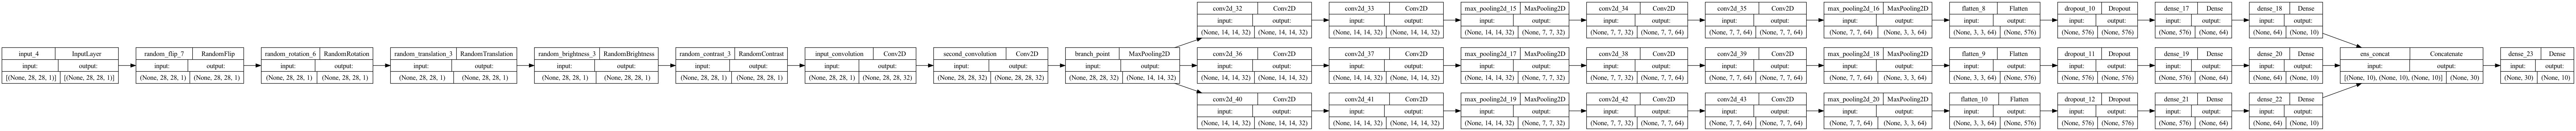

In [32]:
%%time

from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# add in augmentations directly
x = RandomFlip("horizontal")(input_holder) # flip horizontally
x = RandomRotation(0.05)(x) # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # move by 10%
x = RandomBrightness(factor=0.1, value_range=(0.0, 1.0))(x) # add some to the mean
x = RandomContrast(0.1)(x) # add or decrease contrast

# start with a conv layer
x = Conv2D(filters=32, name='input_convolution',
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(x)

x = Conv2D(filters=32, name='second_convolution',
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)

# now save this tensor to use in mutliple branches
input_conv = MaxPooling2D(pool_size=(2, 2), 
               data_format='channels_last', name='branch_point')(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = Concatenate(name='ens_concat')(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder, outputs=x)

cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# build call not needed here because we already defined the input size
print(cnn_ens.summary())

plot_model(
    cnn_ens, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [33]:
%%time

# now fit with random augmentations applied during training only
cnn_ens.fit(ds_train, batch_size=128, 
           epochs=50, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
        )



Epoch 1/50
469/469 [==============================] - 56s 113ms/step - loss: 0.8928 - accuracy: 0.6746 - val_loss: 0.5527 - val_accuracy: 0.7935
Epoch 2/50
469/469 [==============================] - 57s 122ms/step - loss: 0.5858 - accuracy: 0.7823 - val_loss: 0.4692 - val_accuracy: 0.8345
Epoch 3/50
469/469 [==============================] - 57s 123ms/step - loss: 0.5127 - accuracy: 0.8121 - val_loss: 0.4305 - val_accuracy: 0.8466
Epoch 4/50
469/469 [==============================] - 58s 123ms/step - loss: 0.4666 - accuracy: 0.8299 - val_loss: 0.4086 - val_accuracy: 0.8522
Epoch 5/50
469/469 [==============================] - 57s 121ms/step - loss: 0.4291 - accuracy: 0.8414 - val_loss: 0.3731 - val_accuracy: 0.8645
Epoch 6/50
469/469 [==============================] - 56s 119ms/step - loss: 0.4066 - accuracy: 0.8500 - val_loss: 0.3595 - val_accuracy: 0.8703
Epoch 7/50
469/469 [==============================] - 55s 118ms/step - loss: 0.3863 - accuracy: 0.8589 - val_loss: 0.3188 - val_ac

79/79 [==============================] - 1s 10ms/step


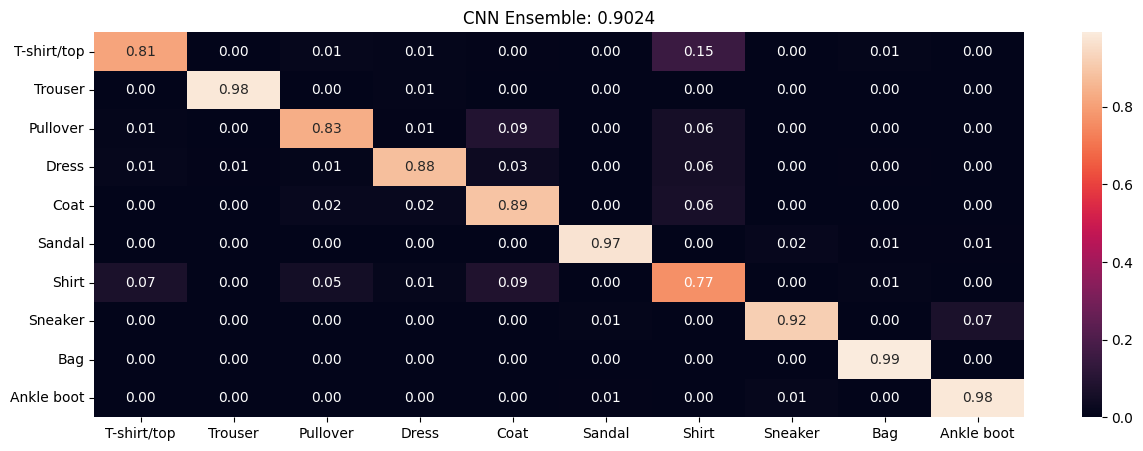

In [34]:
summarize_net(cnn_ens, ds_test, title_text='CNN Ensemble:')

___
# Adding ResNet Style Blocks
Okay, so now lets try a trick from 2016---ancient in terms of deep learning years (that's a joke 🤷, ¯\\_(ツ)_/¯). 

The ResNet-Style Bypass is described in the following:
![resnet](https://cdn-images-1.medium.com/max/1600/0*0r0vS8myiqyOb79L.jpg)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 random_flip_8 (RandomFlip)     (None, 28, 28, 1)    0           ['input_5[0][0]']                
                                                                                                  
 random_rotation_7 (RandomRotat  (None, 28, 28, 1)   0           ['random_flip_8[0][0]']          
 ion)                                                                                             
                                                                                                  
 random_translation_4 (RandomTr  (None, 28, 28, 1)   0           ['random_rotation_7[0][0]']

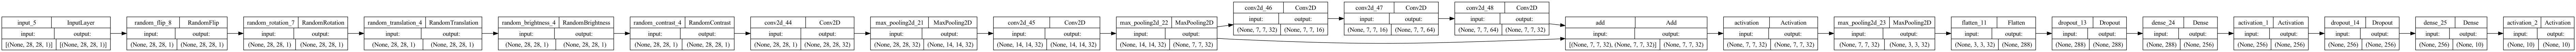

In [35]:
# now lets use a residual architecture
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

input_holder = Input(shape=(img_wh, img_wh, 1))

# add in augmentations directly
x = RandomFlip("horizontal")(input_holder) # flip horizontally
x = RandomRotation(0.05)(x) # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # move by 10%
x = RandomBrightness(factor=0.1, value_range=(0.0, 1.0))(x) # add some to the mean
x = RandomContrast(0.1)(x) # add or decrease contrast

# use conv layers with max pooling to get smaller spatial resolution
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# notice that we save this as 'x_split' so we can use the tensor later
x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

# use 1x1 filters here to reduce the number of outputs
x = Conv2D(filters=16,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

# now the filters we use here have fewer paraameters becasue the channels are reduced
# from the 1x1 layer
x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now use 1x1 filters to get back to the original size, so we can add
x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# build call not needed here because we already defined the input size
print(resnet.summary())

plot_model(
    resnet, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)



In [37]:
%%time


resnet.fit(ds_train, batch_size=512,  # make larger batch size to speed up computations
           epochs=50, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
        )

Epoch 1/50
469/469 [==============================] - 27s 54ms/step - loss: 0.9874 - accuracy: 0.6378 - val_loss: 0.5897 - val_accuracy: 0.7849
Epoch 2/50
469/469 [==============================] - 24s 50ms/step - loss: 0.6447 - accuracy: 0.7613 - val_loss: 0.5136 - val_accuracy: 0.8158
Epoch 3/50
469/469 [==============================] - 23s 49ms/step - loss: 0.5728 - accuracy: 0.7905 - val_loss: 0.4673 - val_accuracy: 0.8272
Epoch 4/50
469/469 [==============================] - 23s 49ms/step - loss: 0.5346 - accuracy: 0.8036 - val_loss: 0.4349 - val_accuracy: 0.8441
Epoch 5/50
469/469 [==============================] - 24s 52ms/step - loss: 0.5065 - accuracy: 0.8130 - val_loss: 0.4185 - val_accuracy: 0.8485
Epoch 6/50
469/469 [==============================] - 23s 49ms/step - loss: 0.4837 - accuracy: 0.8216 - val_loss: 0.3957 - val_accuracy: 0.8535
Epoch 7/50
469/469 [==============================] - 24s 52ms/step - loss: 0.4665 - accuracy: 0.8286 - val_loss: 0.3818 - val_accuracy:

79/79 [==============================] - 1s 5ms/step


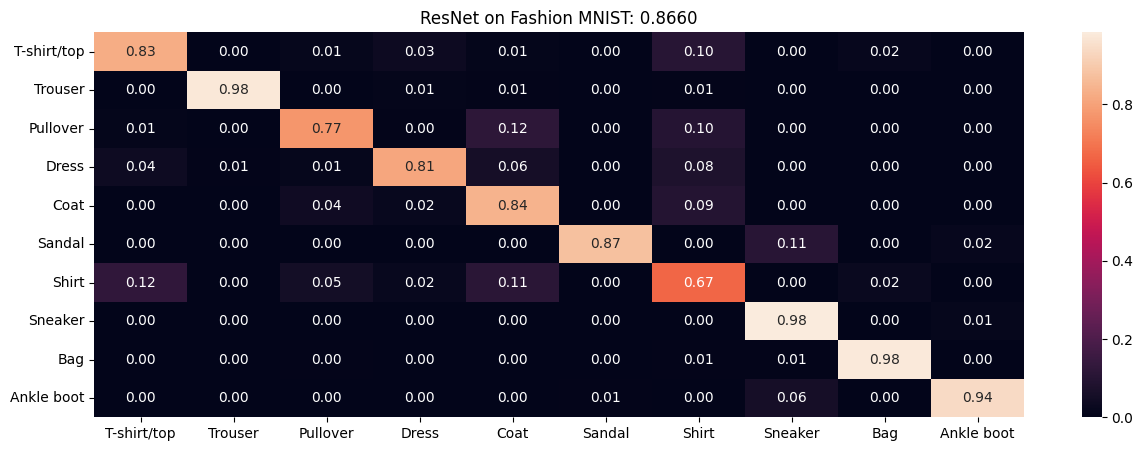

In [38]:
summarize_net(resnet, ds_test, title_text='ResNet on Fashion MNIST:')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 random_flip_9 (RandomFlip)     (None, 28, 28, 1)    0           ['input_6[0][0]']                
                                                                                                  
 random_rotation_8 (RandomRotat  (None, 28, 28, 1)   0           ['random_flip_9[0][0]']          
 ion)                                                                                             
                                                                                                  
 random_translation_5 (RandomTr  (None, 28, 28, 1)   0           ['random_rotation_8[0][0]']

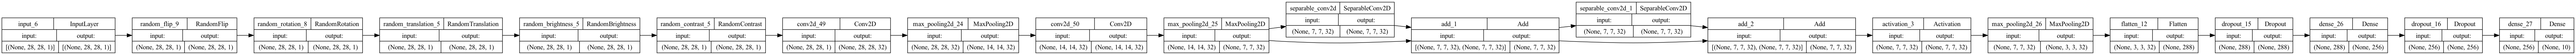

In [39]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# add in augmentations directly
x = RandomFlip("horizontal")(input_holder) # flip horizontally
x = RandomRotation(0.05)(x) # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # move by 10%
x = RandomBrightness(factor=0.1, value_range=(0.0, 1.0))(x) # add some to the mean
x = RandomContrast(0.1)(x) # add or decrease contrast

# start with a traditional conv layer, reduce spatial dimensions
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

# here we use the separabl convolution
x = SeparableConv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

print(xception.summary())

plot_model(
    xception, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [40]:
%%time 

xception.fit(ds_train, batch_size=512,  # make larger batch size to speed up computations
           epochs=50, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
        )

Epoch 1/50
469/469 [==============================] - 711s 2s/step - loss: 1.0083 - accuracy: 0.6265 - val_loss: 0.6349 - val_accuracy: 0.7659
Epoch 2/50
469/469 [==============================] - 1573s 3s/step - loss: 0.6760 - accuracy: 0.7486 - val_loss: 0.5227 - val_accuracy: 0.8080
Epoch 3/50
469/469 [==============================] - 21s 44ms/step - loss: 0.6095 - accuracy: 0.7729 - val_loss: 0.4806 - val_accuracy: 0.8254
Epoch 4/50
469/469 [==============================] - 19s 40ms/step - loss: 0.5738 - accuracy: 0.7863 - val_loss: 0.4707 - val_accuracy: 0.8230
Epoch 5/50
469/469 [==============================] - 18s 39ms/step - loss: 0.5389 - accuracy: 0.8013 - val_loss: 0.4315 - val_accuracy: 0.8376
Epoch 6/50
469/469 [==============================] - 19s 40ms/step - loss: 0.5134 - accuracy: 0.8095 - val_loss: 0.4308 - val_accuracy: 0.8462
Epoch 7/50
469/469 [==============================] - 19s 40ms/step - loss: 0.4963 - accuracy: 0.8158 - val_loss: 0.3968 - val_accuracy: 

79/79 [==============================] - 1s 6ms/step


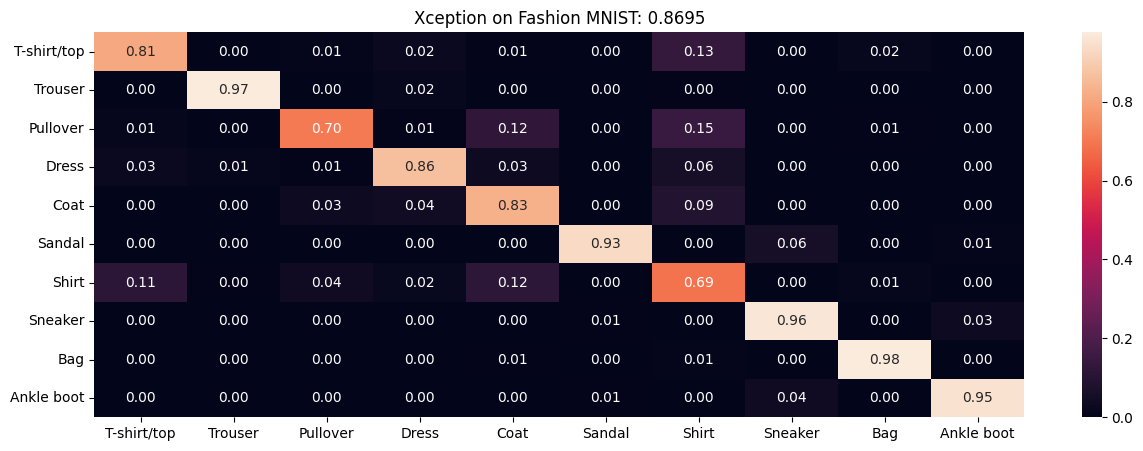

In [42]:
summarize_net(xception, ds_test, title_text='Xception on Fashion MNIST:')

# Using Pre-trained Models
You also have fantastic access to different pre-trained models such as Xception, DenseNet, ResNest, VGG, and many other. For an updated key of available models see:
- https://keras.io/applications/

In [ ]:
# # workaround for multiple OpenMP on Mac
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [43]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')
res_model.summary()

102967424/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
          

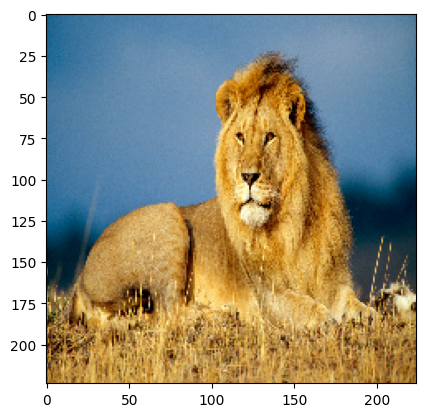

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

def get_image(img_path):
    
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(image.img_to_array(img)/255)
    plt.grid(False)
    return image.img_to_array(img)

img_path = 'data/Simba.jpg'
x = get_image(img_path)

In [47]:

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 5us/step
Predicted: [('n02129165', 'lion', 0.99564725), ('n02130308', 'cheetah', 0.0013233833), ('n07802026', 'hay', 0.0010097771)]


1/1 [==============================] - 0s 84ms/step
Predicted: [('n04285008', 'sports_car', 0.82310474), ('n03100240', 'convertible', 0.0750389), ('n02974003', 'car_wheel', 0.06684494), ('n03459775', 'grille', 0.025561811), ('n04037443', 'racer', 0.0042373436), ('n03770679', 'minivan', 0.0017386357), ('n02814533', 'beach_wagon', 0.0015378448), ('n04483307', 'trimaran', 0.0005192575), ('n03930630', 'pickup', 0.00032711955), ('n03670208', 'limousine', 0.00025701433)]


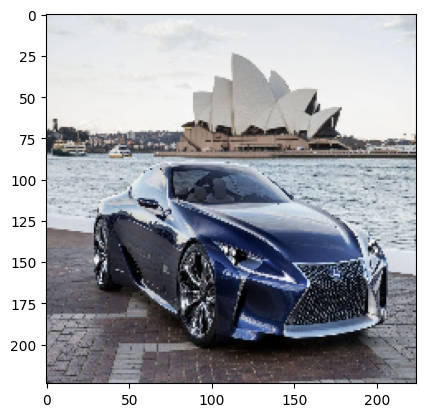

In [48]:
img_path = 'data/MyCar.jpg'
x = get_image(img_path)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=10)[0])

_____
_____
**Self Test: Should we do this Live?**

- A. Yes.
- B. No.
- C. It Depends
- D. We're gonna do it anyway

If you have OpenCV installed, you can try this.

# Imposter Syndrome:

<img src="https://i.imgflip.com/29pmyu.jpg" width=500>


In [1]:
import cv2
import numpy as np
import time
import itertools
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

if 'res_model' not in locals():
    res_model = ResNet50(weights='imagenet')

ESC_KEY = 27

# setup some windows for viewing
cv2.namedWindow("demowin1")
cv2.startWindowThread()

# open the video card for capture
vc = cv2.VideoCapture(0)

if vc.isOpened():  # try to get the first frame
    print ("vc opened, getting first frame")
    rval, frame = vc.read()
    # this will likely fail the first time
    # the webcam often needs some time to open fully
    key = 0
else:
    print ("vc not open, exiting")
    key = ESC_KEY

while key != ESC_KEY and vc.isOpened():  # the escape key and the capture device is open
    rval, frame = vc.read()
    key = cv2.waitKey(10)

    if rval and frame is not None:
        
        frame_to_show = cv2.pyrDown(frame)  # make smaller immediately
        # grab the ROI in top left (will show later on)
        frame_down = frame_to_show[0:224,0:224]
        
        # increase contrast
        img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
        frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

        # and then remove noise
        frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,10,7,21)
# h (Optional): filter strength (luminance). Larger h value removes noise but alsoß image details
# hColor (Optional):  The same as h but for color components. 
#    For most images value equals 10 will be enough to remove noise and not distort colors
# templateWindowSize (Optional): Size in pixels of the template patch that is used to compute weights. Should be odd. 
#    Recommended value 7 pixels
# searchWindowSize (Optional): Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. 
#    Recommended value 21 pixels
        
        img = frame_down.copy() # make a copy for numpy

        x = image.img_to_array(img[:,:,::-1]) # convert to numpy
        x = np.expand_dims(x, axis=0) # add batch dimension
        x = preprocess_input(x) # apply resnet presets

        preds = res_model.predict(x, verbose=0) # get the predictions
        
        # decode the results into a list of tuples (class, description, probability)
        txt = str(decode_predictions(preds, top=3)[0])

        cv2.putText(frame_to_show, txt, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255])
        cv2.rectangle(frame_to_show, (0,0), (224,224), (255,255,255), 1)
        cv2.imshow("demowin1", frame_to_show)
    
print('releasing...')
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('Done')

Metal device set to: Apple M2
vc opened, getting first frame


2023-11-15 15:42:22.080050: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


releasing...
Done


# Transfer Learning With ResNet
Let's do some learning based on the rock/paper/scissors dataset. In this example, I will use the tensorflow_datasets package for managing and dowloading the data.

In [1]:
import tensorflow_datasets as tfds

ds_train = tfds.load('rock_paper_scissors', split='train', shuffle_files=True)
ds_test = tfds.load('rock_paper_scissors', split='test', shuffle_files=False)

Metal device set to: Apple M2


In [2]:
for element in ds_train.take(1):
    print(element['image'].shape)
    print(element['label'].numpy())

(300, 300, 3)
1


2023-08-16 21:32:36.329497: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


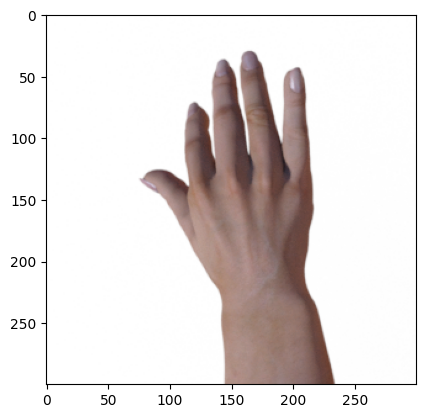

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(element['image'].numpy())
plt.grid(False)

In [4]:
# connect new layers to the output
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
import numpy as np

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = element['image'].numpy()
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

1/1 [==============================] - 1s 645ms/step
CPU times: user 610 ms, sys: 59.7 ms, total: 670 ms
Wall time: 669 ms


(1, 10, 10, 2048)

In [5]:
x=preprocess_input(tf.expand_dims(element['image'], axis=0))
preds = res_no_top.predict(x)
preds.shape

1/1 [==============================] - 1s 713ms/step


(1, 10, 10, 2048)

In [6]:
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Input, Dense
from tensorflow.keras.models import Model

NUM_CLASSES = 3

# let's add a fully-connected layer
input_x = Input(shape=preds.shape[1:])

x = SeparableConv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(input_x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dense(100, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 separable_conv2d (Separable  (None, 10, 10, 32)       84000     
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 100)               80100     
                                                                 
 dense_1 (Dense)             (None, 3)                 303   

In [7]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam

ds_train = ds_train.batch(32, drop_remainder=True)
ds_train = ds_train.prefetch(32)

ds_test = ds_test.batch(32, drop_remainder=True)
ds_test = ds_test.prefetch(32)


In [8]:
%%time

opt = Adam() #default optimizer parameters
num_epochs = 5

for e in range(num_epochs):
    # iterating over this is one full epoch
    for element in ds_train:
        # now the features and labels are for one batch
        with tf.GradientTape(watch_accessed_variables=False, persistent=False) as tape:
            # only watch the variables for this smaller model, to save time
            tape.watch(model.trainable_variables)
            
            # run through the pre-trained processor
            images = preprocess_input(element['image'])
            
            # and place through the pre-trained model
            features = res_no_top(images)
            
            # put through the custom model
            yhat = model(features)
            
            # get the loss function
            # notice that the label is an integer, yhat is a vector
            # the 'sparse' keyword makes this the function expectation
            loss = sparse_categorical_crossentropy(tf.squeeze(element['label']), tf.squeeze(yhat))
                        
        # update via auto diff and specified optimizer
        # only update the model head here
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        
    print(f'Finished epoch {e}')
       

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
CPU times: user 1min 19s, sys: 23.1 s, total: 1min 42s
Wall time: 2min 50s


In [9]:
num_points = 0
num_correct = 0

for element in ds_test:
    # run through the pre-trained processor
    images = preprocess_input(element['image'])
    # and place through the pre-trained model
    features = res_no_top(images)
    # put through the custom model
    yhat = model(features)

    # get the total batch number
    num_points += len(element['label'].numpy())

    # convert model output to an integer
    yhat = np.argmax(yhat.numpy(),axis=1)

    num_correct += sum(np.squeeze(yhat)==element['label'].numpy())
    
num_correct / num_points

0.7926136363636364